<a href="https://colab.research.google.com/github/henry-del/assignment2/blob/master/BERT%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E_0(%E6%9B%B4%E6%96%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
import pandas as pd
import numpy as np
import random
import math

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 訓練模型用評分結果-01+02+03.xlsx to 訓練模型用評分結果-01+02+03 (4).xlsx


In [ ]:
data=pd.read_excel("訓練模型用評分結果-01+02+03.xlsx")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   1            543 non-null    int64 
 1   打籃球          543 non-null    object
 2   因為它的圖中有打籃球   543 non-null    object
 3   晴日與雨天        543 non-null    object
 4   因為圖中有有晴天和雨天  543 non-null    object
dtypes: int64(1), object(4)
memory usage: 21.3+ KB


In [ ]:
data.columns=['score','story1','story2','story3','story4']

In [ ]:
data

,score,story1,story2,story3,story4
0,1,去打籃球,因為它的圖中有打籃球,今天天氣,因為圖中有天氣，是雨天和晴天
1,1,打籃球趣,"他們去打來球,打到一半的時候,突然下起噢。",去打籃球,他們
2,1,打籃球趣,"他們去打籃球,打到一半的時候,突然下雨又打雷了。",去打籃球,",他"
3,0,up的籃球比賽.,"第一張是陰天的圖案,第二張有人在打籃球,但突然下雨了\n所以這場比賽沒比完就結束了",未作答,未作答
4,0,下雨的時候,下雨的時候，不能打籃球。,沒有好天氣,原ㄌ
...,...,...,...,...,...
538,1,天氣,看到有兩個有天氣的圖片,打籃球,看到有兩個人在打籃球
539,1,作怪的天氣,原本天氣晴朗和朋友在打球\n但是突然烏雲密布,籃球生涯,一開始打籃球會很高興\n但是之後有低潮
540,1,一起來打球,看到兩個小孩在籃球場打球,下雨了,"原本是晴天,兩個人去打球,突然下起了大雨"
541,1,周末,我跟朋友在打球然後下雨了,下雨,我們在打球時下雨了我們沒帶傘


In [ ]:
data['story']=data['story1']+data['story2']+data['story3']+data['story4']

In [ ]:
data=data.drop(['story1','story2','story3','story4'], axis=1)

In [ ]:
data['story']=data['story'].apply(str)

In [ ]:
len(data)

543

In [ ]:
data.isnull().any()

score    False
story    False
dtype: bool

In [ ]:
data.shape

(543, 2)

In [ ]:
data.columns.values

array(['score', 'story'], dtype=object)

In [ ]:
data['score']=tf.cast(data['score'], tf.float32)

In [ ]:
data.dtypes

score    float32
story     object
dtype: object

In [ ]:
#def tran_cat_to_num(data):
#    if data['score'] == 1:
#        return 1.0
#    elif data['score'] == 0:
#        return 0.0
#    else:
#      return 1.0
#data['score']=data.apply(tran_cat_to_num,axis=1)
#data

In [ ]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(data,test_size=0.4,stratify=np.array(data['score']))
#valid,test= train_test_split(test,test_size=0.5,stratify=np.array(test['score']))

In [ ]:
data['score'].value_counts()

1.0    381
2.0     82
0.0     80
Name: score, dtype: int64

In [ ]:
train['score'].value_counts()

1.0    228
2.0     49
0.0     48
Name: score, dtype: int64

In [ ]:
test['score'].value_counts()

1.0    153
2.0     33
0.0     32
Name: score, dtype: int64

In [ ]:
#valid['score'].value_counts()

In [ ]:
pip install transformers

In [ ]:
from transformers import BertTokenizer
PRETRAINED_MODEL_NAME = "bert-base-chinese"  # 指定繁簡中文 BERT-BASE 預訓練模型
# 取得此預訓練模型所使用的 tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [ ]:
max_length_test = 80
test_sentence = '4455444456444400128'
test_sentence_with_special_tokens = '[CLS]' + test_sentence + '[SEP]'
tokenized = tokenizer.tokenize(test_sentence_with_special_tokens)
print('tokenized', tokenized)

# convert tokens to ids in WordPiece
input_ids = tokenizer.convert_tokens_to_ids(tokenized)
  
# precalculation of pad length, so that we can reuse it later on
padding_length = max_length_test - len(input_ids)

# map tokens to WordPiece dictionary and add pad token for those text shorter than our max length
input_ids = input_ids + ([0] * padding_length)

# attention should focus just on sequence with non padded tokens
attention_mask = [1] * len(input_ids)

# do not focus attention on padded tokens
attention_mask = attention_mask + ([0] * padding_length)

# token types, needed for example for question answering, for our purpose we will just set 0 as we have just one sequence
token_type_ids = [0] * max_length_test
bert_input = {
    "token_ids": input_ids,
    "token_type_ids": token_type_ids,
    "attention_mask": attention_mask
} 
print(bert_input)


tokenized ['[CLS]', '445', '##54', '##44', '##45', '##64', '##44', '##400', '##12', '##8', '[SEP]']
{'token_ids': [101, 12834, 9488, 9292, 9039, 9165, 9292, 10765, 8455, 8156, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
bert_input = tokenizer.encode_plus(
                        test_sentence,                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        max_length = max_length_test, # max length of the text that can go to BERT
                        pad_to_max_length = True, # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
              )
print('encoded', bert_input)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


encoded {'input_ids': [101, 12834, 9488, 9292, 9039, 9165, 9292, 10765, 8455, 8156, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
def convert_example_to_feature(review):
  max_length=80
  # combine step for tokenization, WordPiece vector mapping, adding special tokens as well as truncating reviews longer than the max length
  
  return tokenizer.encode_plus(review, 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )


In [ ]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [ ]:
def encode_examples(data):
  
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []    
  for story,score in zip(list(data['story']),list(data['score'])):
    
    bert_input = convert_example_to_feature(story)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([score])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)


In [ ]:
batch_size=80

In [ ]:
# train dataset
ds_train_encoded = encode_examples(train).shuffle(10).batch(batch_size)

# test dataset
ds_test_encoded = encode_examples(test).batch(batch_size)

#valid dataset
#ds_val_encoded = encode_examples(valid).batch(batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#from transformers import TFBertForSequenceClassification,BertTokenizer
#import tensorflow as tf

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
#learning_rate =5e-6

# we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
#number_of_epochs = 15


# model initialization
###model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
#tokenizer = BertTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext-large")
#model = BertModel.from_pretrained("hfl/chinese-roberta-wwm-ext-large")
#model = TFBertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=3)
#optimizer =  tf.keras.optimizers.Adam(learning_rate=learning_rate)
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 


# random labels_dict
#labels_dict = {0:49,1:76,2:11}

#class_weight=create_class_weight(labels_dict)
#fit model
#bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_val_encoded)

# evaluate test set
#model.evaluate(ds_test_encoded)



# choosing Adam optimizer
#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

#model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn import model_selection
from transformers import TFBertForSequenceClassification,BertTokenizer
import tensorflow as tf
# data sample
# prepare cross validation
learning_rate =2e-5
number_of_epochs =8
metric_accuracy=[]
metric_loss=[]
predict=[]
actual=[]
X,y=data['story'],data['score']
kf = KFold(n_splits=10)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  X_train,y_train = X_train.to_frame(),y_train.to_frame() 
  X_test,y_test = X_test.to_frame(),y_test.to_frame() 
  train= pd.DataFrame(X_train,columns=['story'])
  train= pd.concat([train,pd.DataFrame(y_train,columns=['score'])],axis=1)
  test= pd.DataFrame(X_test,columns=['story'])
  test= pd.concat([test,pd.DataFrame(y_test,columns=['score'])], axis=1)
  batch_size=64
  ds_train_encoded = encode_examples(train).shuffle(10).batch(batch_size)
  ds_test_encoded = encode_examples(test).batch(batch_size)
  model = TFBertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=3)
  optimizer =  tf.keras.optimizers.Nadam(learning_rate=learning_rate)
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_train_encoded)
  loss,accuracy=model.evaluate(ds_test_encoded)
  metric_accuracy.append(accuracy)
  metric_loss.append(loss)
  A=tf.nn.softmax(model.predict(ds_test_encoded)[0])
  B=np.argmax(A,1)
  predict.append(B)
  actual.append(pd.to_numeric(y_test['score']))
print("results",metric_accuracy)
print(f"Mean-Precision: {sum(metric_accuracy) / len(metric_accuracy)}")    
print("results",metric_loss)
print(f"Mean-loss: {sum(metric_loss) / len(metric_loss)}")    

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
8/8 [==============================] - 34s 1s/step - loss: 0.8887 - accuracy: 0.6403 - val_loss: 0.5531 - val_accuracy: 0.8238
Epoch 2/8
8/8 [==============================] - 10s 1s/step - loss: 0.5149 - accuracy: 0.8462 - val_loss: 0.4910 - val_accuracy: 0.8258
Epoch 3/8
8/8 [==============================] - 11s 1s/step - loss: 0.4641 - accuracy: 0.8459 - val_loss: 0.4163 - val_accuracy: 0.8914
Epoch 4/8
8/8 [==============================] - 11s 1s/step - loss: 0.3953 - accuracy: 0.8682 - val_loss: 0.2956 - val_accuracy: 0.8811
Epoch 5/8
8/8 [==============================] - 11s 1s/step - loss: 0.3055 - accuracy: 0.8905 - val_loss: 0.2144 - val_accuracy: 0.9529
Epoch 6/8
8/8 [==============================] - 11s 1s/step - loss: 0.2540 - accuracy: 0.9196 - val_loss: 0.2069 - val_accuracy: 0.9734
Epoch 7/8
8/8 [==============================] - 11s 1s/step - loss: 0.2170 - accuracy: 0.9375 - val_loss: 0.1304 - val_accuracy: 0.9693
Epoch 8/8
1/1 [==========================

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
8/8 [==============================] - 33s 2s/step - loss: 0.8355 - accuracy: 0.6611 - val_loss: 0.5353 - val_accuracy: 0.8176
Epoch 2/8
8/8 [==============================] - 11s 1s/step - loss: 0.5062 - accuracy: 0.8294 - val_loss: 0.4061 - val_accuracy: 0.8893
Epoch 3/8
8/8 [==============================] - 11s 1s/step - loss: 0.4047 - accuracy: 0.8508 - val_loss: 0.2814 - val_accuracy: 0.9426
Epoch 4/8
8/8 [==============================] - 11s 1s/step - loss: 0.3388 - accuracy: 0.8909 - val_loss: 0.2199 - val_accuracy: 0.9590
Epoch 5/8
8/8 [==============================] - 11s 1s/step - loss: 0.2546 - accuracy: 0.9311 - val_loss: 0.1538 - val_accuracy: 0.9693
Epoch 6/8
8/8 [==============================] - 11s 1s/step - loss: 0.1740 - accuracy: 0.9629 - val_loss: 0.1135 - val_accuracy: 0.9816
Epoch 7/8
8/8 [==============================] - 11s 1s/step - loss: 0.1275 - accuracy: 0.9812 - val_loss: 0.0917 - val_accuracy: 0.9795
Epoch 8/8
1/1 [==========================

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
8/8 [==============================] - 34s 2s/step - loss: 1.0154 - accuracy: 0.4779 - val_loss: 0.5847 - val_accuracy: 0.7992
Epoch 2/8
8/8 [==============================] - 11s 1s/step - loss: 0.5628 - accuracy: 0.8094 - val_loss: 0.4188 - val_accuracy: 0.8811
Epoch 3/8
8/8 [==============================] - 11s 1s/step - loss: 0.4296 - accuracy: 0.8469 - val_loss: 0.4002 - val_accuracy: 0.8443
Epoch 4/8
8/8 [==============================] - 11s 1s/step - loss: 0.3996 - accuracy: 0.8646 - val_loss: 0.2262 - val_accuracy: 0.9406
Epoch 5/8
8/8 [==============================] - 11s 1s/step - loss: 0.2524 - accuracy: 0.9178 - val_loss: 0.1487 - val_accuracy: 0.9631
Epoch 6/8
8/8 [==============================] - 11s 1s/step - loss: 0.3246 - accuracy: 0.8688 - val_loss: 0.1342 - val_accuracy: 0.9713
Epoch 7/8
8/8 [==============================] - 11s 1s/step - loss: 0.1563 - accuracy: 0.9652 - val_loss: 0.1140 - val_accuracy: 0.9816
Epoch 8/8
1/1 [==========================

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
8/8 [==============================] - 34s 2s/step - loss: 0.7670 - accuracy: 0.7232 - val_loss: 0.4477 - val_accuracy: 0.8384
Epoch 2/8
8/8 [==============================] - 11s 1s/step - loss: 0.4508 - accuracy: 0.8584 - val_loss: 0.4576 - val_accuracy: 0.8384
Epoch 3/8
8/8 [==============================] - 11s 1s/step - loss: 0.3740 - accuracy: 0.8644 - val_loss: 0.2767 - val_accuracy: 0.9284
Epoch 4/8
8/8 [==============================] - 11s 1s/step - loss: 0.3091 - accuracy: 0.8936 - val_loss: 0.1959 - val_accuracy: 0.9468
Epoch 5/8
8/8 [==============================] - 11s 1s/step - loss: 0.2411 - accuracy: 0.9168 - val_loss: 0.1490 - val_accuracy: 0.9652
Epoch 6/8
8/8 [==============================] - 11s 1s/step - loss: 0.1585 - accuracy: 0.9640 - val_loss: 0.1209 - val_accuracy: 0.9796
Epoch 7/8
8/8 [==============================] - 11s 1s/step - loss: 0.2335 - accuracy: 0.9217 - val_loss: 0.1017 - val_accuracy: 0.9816
Epoch 8/8
1/1 [==========================

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
8/8 [==============================] - 34s 2s/step - loss: 0.8372 - accuracy: 0.6595 - val_loss: 0.5501 - val_accuracy: 0.8344
Epoch 2/8
8/8 [==============================] - 11s 1s/step - loss: 0.5212 - accuracy: 0.8433 - val_loss: 0.4317 - val_accuracy: 0.8425
Epoch 3/8
8/8 [==============================] - 11s 1s/step - loss: 0.4098 - accuracy: 0.8547 - val_loss: 0.3721 - val_accuracy: 0.8855
Epoch 4/8
8/8 [==============================] - 11s 1s/step - loss: 0.3557 - accuracy: 0.8627 - val_loss: 0.3113 - val_accuracy: 0.9284
Epoch 5/8
8/8 [==============================] - 11s 1s/step - loss: 0.2961 - accuracy: 0.9031 - val_loss: 0.2021 - val_accuracy: 0.9468
Epoch 6/8
8/8 [==============================] - 11s 1s/step - loss: 0.2704 - accuracy: 0.9079 - val_loss: 0.1485 - val_accuracy: 0.9632
Epoch 7/8
8/8 [==============================] - 11s 1s/step - loss: 0.1577 - accuracy: 0.9625 - val_loss: 0.0995 - val_accuracy: 0.9836
Epoch 8/8
1/1 [==========================

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
8/8 [==============================] - 33s 2s/step - loss: 0.8610 - accuracy: 0.7009 - val_loss: 0.6680 - val_accuracy: 0.6994
Epoch 2/8
8/8 [==============================] - 11s 1s/step - loss: 0.6349 - accuracy: 0.7383 - val_loss: 0.4868 - val_accuracy: 0.8139
Epoch 3/8
8/8 [==============================] - 11s 1s/step - loss: 0.4794 - accuracy: 0.8358 - val_loss: 0.3829 - val_accuracy: 0.8957
Epoch 4/8
8/8 [==============================] - 11s 1s/step - loss: 0.3754 - accuracy: 0.8785 - val_loss: 0.3575 - val_accuracy: 0.8691
Epoch 5/8
8/8 [==============================] - 11s 1s/step - loss: 0.2924 - accuracy: 0.9126 - val_loss: 0.1956 - val_accuracy: 0.9571
Epoch 6/8
8/8 [==============================] - 11s 1s/step - loss: 0.2959 - accuracy: 0.8829 - val_loss: 0.1437 - val_accuracy: 0.9755
Epoch 7/8
8/8 [==============================] - 11s 1s/step - loss: 0.1527 - accuracy: 0.9715 - val_loss: 0.0915 - val_accuracy: 0.9836
Epoch 8/8
1/1 [==========================

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
8/8 [==============================] - 33s 2s/step - loss: 0.9980 - accuracy: 0.5107 - val_loss: 0.6251 - val_accuracy: 0.8139
Epoch 2/8
8/8 [==============================] - 11s 1s/step - loss: 0.5877 - accuracy: 0.8215 - val_loss: 0.4371 - val_accuracy: 0.8282
Epoch 3/8
8/8 [==============================] - 11s 1s/step - loss: 0.4462 - accuracy: 0.8428 - val_loss: 0.3267 - val_accuracy: 0.9141
Epoch 4/8
8/8 [==============================] - 11s 1s/step - loss: 0.3400 - accuracy: 0.8855 - val_loss: 0.2238 - val_accuracy: 0.9509
Epoch 5/8
8/8 [==============================] - 11s 1s/step - loss: 0.2382 - accuracy: 0.9463 - val_loss: 0.1369 - val_accuracy: 0.9632
Epoch 6/8
8/8 [==============================] - 11s 1s/step - loss: 0.2251 - accuracy: 0.9282 - val_loss: 0.0955 - val_accuracy: 0.9836
Epoch 7/8
8/8 [==============================] - 11s 1s/step - loss: 0.2150 - accuracy: 0.9216 - val_loss: 0.1015 - val_accuracy: 0.9836
Epoch 8/8
1/1 [==========================

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
8/8 [==============================] - 33s 2s/step - loss: 0.9813 - accuracy: 0.5505 - val_loss: 0.6842 - val_accuracy: 0.7546
Epoch 2/8
8/8 [==============================] - 11s 1s/step - loss: 0.6487 - accuracy: 0.7651 - val_loss: 0.4825 - val_accuracy: 0.8303
Epoch 3/8
8/8 [==============================] - 11s 1s/step - loss: 0.4983 - accuracy: 0.8372 - val_loss: 0.3836 - val_accuracy: 0.8344
Epoch 4/8
8/8 [==============================] - 11s 1s/step - loss: 0.3887 - accuracy: 0.8542 - val_loss: 0.3041 - val_accuracy: 0.9141
Epoch 5/8
8/8 [==============================] - 11s 1s/step - loss: 0.3535 - accuracy: 0.8764 - val_loss: 0.2551 - val_accuracy: 0.9223
Epoch 6/8
8/8 [==============================] - 11s 1s/step - loss: 0.3082 - accuracy: 0.8955 - val_loss: 0.1959 - val_accuracy: 0.9509
Epoch 7/8
8/8 [==============================] - 11s 1s/step - loss: 0.2147 - accuracy: 0.9376 - val_loss: 0.1367 - val_accuracy: 0.9775
Epoch 8/8
1/1 [==========================

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
8/8 [==============================] - 32s 2s/step - loss: 0.8678 - accuracy: 0.6524 - val_loss: 0.5519 - val_accuracy: 0.8303
Epoch 2/8
8/8 [==============================] - 11s 1s/step - loss: 0.5225 - accuracy: 0.8447 - val_loss: 0.4343 - val_accuracy: 0.8875
Epoch 3/8
8/8 [==============================] - 11s 1s/step - loss: 0.4176 - accuracy: 0.8661 - val_loss: 0.4084 - val_accuracy: 0.8896
Epoch 4/8
8/8 [==============================] - 11s 1s/step - loss: 0.3534 - accuracy: 0.8817 - val_loss: 0.2664 - val_accuracy: 0.9182
Epoch 5/8
8/8 [==============================] - 11s 1s/step - loss: 0.3295 - accuracy: 0.8661 - val_loss: 0.1904 - val_accuracy: 0.9571
Epoch 6/8
8/8 [==============================] - 11s 1s/step - loss: 0.2199 - accuracy: 0.9491 - val_loss: 0.1463 - val_accuracy: 0.9714
Epoch 7/8
8/8 [==============================] - 11s 1s/step - loss: 0.1549 - accuracy: 0.9691 - val_loss: 0.1143 - val_accuracy: 0.9775
Epoch 8/8
1/1 [==========================

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
8/8 [==============================] - 33s 2s/step - loss: 1.0623 - accuracy: 0.4544 - val_loss: 0.6205 - val_accuracy: 0.8139
Epoch 2/8
8/8 [==============================] - 11s 1s/step - loss: 0.5985 - accuracy: 0.8207 - val_loss: 0.4517 - val_accuracy: 0.8303
Epoch 3/8
8/8 [==============================] - 11s 1s/step - loss: 0.4562 - accuracy: 0.8450 - val_loss: 0.3524 - val_accuracy: 0.8814
Epoch 4/8
8/8 [==============================] - 11s 1s/step - loss: 0.3665 - accuracy: 0.8627 - val_loss: 0.3078 - val_accuracy: 0.9141
Epoch 5/8
8/8 [==============================] - 11s 1s/step - loss: 0.3041 - accuracy: 0.8994 - val_loss: 0.1890 - val_accuracy: 0.9407
Epoch 6/8
8/8 [==============================] - 11s 1s/step - loss: 0.2851 - accuracy: 0.8956 - val_loss: 0.1283 - val_accuracy: 0.9755
Epoch 7/8
8/8 [==============================] - 11s 1s/step - loss: 0.1614 - accuracy: 0.9695 - val_loss: 0.0836 - val_accuracy: 0.9857
Epoch 8/8
1/1 [==========================

In [ ]:
predict_list=[]
for i in range(len(predict)):
  predict_list.extend(list(predict[i]))

In [ ]:
actual_list=[]
for i in range(len(actual)):
  actual_list.extend(list(actual[i]))

In [ ]:
#A=tf.nn.softmax(model.predict(ds_test_encoded)[0])
#B=np.argmax(A,1)

In [ ]:
#B

In [ ]:
#tf.cast(test['score'], tf.int32).numpy()

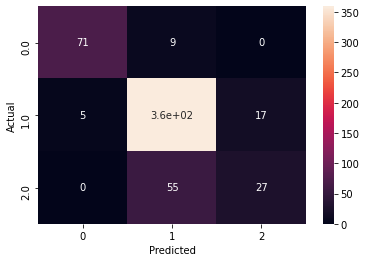

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':  actual_list,
        'y_Predicted': predict_list}

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
df
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
#def focal_loss(gamma=2., alpha=4.):
#
#    gamma = float(gamma)
#    alpha = float(alpha)
#
#    def focal_loss_fixed(y_true, y_pred):
#        """Focal loss for multi-classification
#        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
#        Notice: y_pred is probability after softmax
#        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
#        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
#        Focal Loss for Dense Object Detection
#        https://arxiv.org/abs/1708.02002
#
#        Arguments:
#            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
#            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]
#
#        Keyword Arguments:
#            gamma {float} -- (default: {2.0})
#            alpha {float} -- (default: {4.0})
#
#        Returns:
#            [tensor] -- loss.
#        """
#        epsilon = 1.e-9
#        y_true = tf.convert_to_tensor(y_true, tf.float32)
#        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
#
#        model_out = tf.add(y_pred, epsilon)
#        ce = tf.multiply(y_true, -tf.log(model_out))
#        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
#        fl = tf.multiply(alpha, tf.multiply(weight, ce))
#        reduced_fl = tf.reduce_max(fl, axis=1)
#        return tf.reduce_mean(reduced_fl)
#    return focal_loss_fixed

In [ ]:
#text_model.compile(loss="sparse_categorical_crossentropy",
#                       optimizer="adam",
#                       metrics=["sparse_categorical_accuracy"])

In [ ]:
#class_weight = {0 : 18.27, 1: 1., 2:15.46}
#text_model.fit(train_data, epochs=NB_EPOCHS,class_weight=class_weight)

In [ ]:
#predict=text_model.predict(test_data)